<a href="https://colab.research.google.com/github/obeabi/ProjectPortfolio/blob/master/FlightCancellation_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Written by Abiola Obembe
# SDS Challenge #1 - Flight Cancellations
## 2020-10-30



## Problem Statement
I have been hired by the US Department of Transportation (DOT) to analyze data from multiple airline carriers in the United States. The DOT wants to help airline carriers reduce the number of flight cancellations and improve travelers' experiences. My job is to help the DOT predict whether or not a flight will be canceled based on the data provided.

### Data Preprocessing Tools

In [10]:

# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

print('Libraries installed successfully!')

Libraries installed successfully!


In [12]:
# Importing the dataset and check the shape and total number of missing values

df_train = pd.read_csv('public_flights.csv')

df_train.head()



,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,SCHEDULED_TIME,DISTANCE,SCHEDULED_ARRIVAL,CANCELLED
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,205.0,1448,430,0
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,280.0,2330,750,0
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,286.0,2296,806,0
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,285.0,2342,805,0
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,235.0,1448,320,0


In [13]:
# print target column name as a list
target_column = [df_train.columns[-1]]

print(target_column)

['CANCELLED']


In [15]:
# Importing the train-set nd check the shape and total number of missing values

print("The shape of the train-set is:", (df_train.shape))
print("The number of rows in the train-set is:", str(df_train.shape[0]))
print("The number of columns in the train-set is:", str(df_train.shape[1]))

missing_valuestrain = df_train.isnull().sum().sum()

print("The number of missing values in the train-set is:", str(missing_valuestrain))

The shape of the train-set is: (838858, 14)
The number of rows in the train-set is: 838858
The number of columns in the train-set is: 14
The number of missing values in the train-set is: 5983


In [16]:
# create dataframe for test test
df_test = pd.read_csv('pred_flights.csv')
df_test.head()

,2015,2,25,3,WN,1046,N731SA,LAS,PHX,700,65,255,905
0,2015,2,25,3,WN,2251,N279WN,LAS,RNO,700,80,345,820
1,2015,2,25,3,WN,857,N277WN,LAS,SMF,700,90,397,830
2,2015,2,25,3,WN,2864,N8632A,LAX,BWI,700,295,2329,1455
3,2015,2,25,3,WN,3220,N8659D,LAX,PHX,700,80,370,920
4,2015,2,25,3,WN,2954,N789SW,LGA,HOU,700,265,1428,1025


In [17]:
# test set dataframe is missing headers information so we will re-initailize it, deleting the target column label
labels = df_train.columns
new_label= labels[:-1]

new_label
df_test = pd.read_csv('pred_flights.csv', header =None, names = new_label)

df_test.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,SCHEDULED_TIME,DISTANCE,SCHEDULED_ARRIVAL
0,2015,2,25,3,WN,1046,N731SA,LAS,PHX,700,65,255,905
1,2015,2,25,3,WN,2251,N279WN,LAS,RNO,700,80,345,820
2,2015,2,25,3,WN,857,N277WN,LAS,SMF,700,90,397,830
3,2015,2,25,3,WN,2864,N8632A,LAX,BWI,700,295,2329,1455
4,2015,2,25,3,WN,3220,N8659D,LAX,PHX,700,80,370,920


In [18]:
# Importing the test-set and check the shape and total number of missing values

print("The shape of the test-set is:", (df_test.shape))
print("The number of rows in the test-set is:", str(df_test.shape[0]))
print("The number of columns in the test-set is:", str(df_test.shape[1]))

missing_valuestest = df_test.isnull().sum().sum()

print("The number of missing values in the test-set is:", str(missing_valuestest))

The shape of the test-set is: (209717, 13)
The number of rows in the test-set is: 209717
The number of columns in the test-set is: 13
The number of missing values in the test-set is: 1769


### Feature Engineering

In [19]:
# Examine the data types for train dataframe
df_train.dtypes

YEAR                     int64
MONTH                    int64
DAY                      int64
DAY_OF_WEEK              int64
AIRLINE                 object
FLIGHT_NUMBER            int64
TAIL_NUMBER             object
ORIGIN_AIRPORT          object
DESTINATION_AIRPORT     object
SCHEDULED_DEPARTURE      int64
SCHEDULED_TIME         float64
DISTANCE                 int64
SCHEDULED_ARRIVAL        int64
CANCELLED                int64
dtype: object

In [21]:
# Check for data frame info
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 838858 entries, 0 to 838857
Data columns (total 14 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   YEAR                 838858 non-null  int64  
 1   MONTH                838858 non-null  int64  
 2   DAY                  838858 non-null  int64  
 3   DAY_OF_WEEK          838858 non-null  int64  
 4   AIRLINE              838858 non-null  object 
 5   FLIGHT_NUMBER        838858 non-null  int64  
 6   TAIL_NUMBER          832877 non-null  object 
 7   ORIGIN_AIRPORT       838858 non-null  object 
 8   DESTINATION_AIRPORT  838858 non-null  object 
 9   SCHEDULED_DEPARTURE  838858 non-null  int64  
 10  SCHEDULED_TIME       838856 non-null  float64
 11  DISTANCE             838858 non-null  int64  
 12  SCHEDULED_ARRIVAL    838858 non-null  int64  
 13  CANCELLED            838858 non-null  int64  
dtypes: float64(1), int64(9), object(4)
memory usage: 89.6+ MB


In [22]:
# Dealing with missing values in the train-set

df_train.isnull().sum()

YEAR                      0
MONTH                     0
DAY                       0
DAY_OF_WEEK               0
AIRLINE                   0
FLIGHT_NUMBER             0
TAIL_NUMBER            5981
ORIGIN_AIRPORT            0
DESTINATION_AIRPORT       0
SCHEDULED_DEPARTURE       0
SCHEDULED_TIME            2
DISTANCE                  0
SCHEDULED_ARRIVAL         0
CANCELLED                 0
dtype: int64

#### Step 1: Dealing with Missing Values: Tail_number and scheduled_time columns specifically in this project

##### Numerical columns

In [54]:
# Find numerical columns from df_train dataframe
num_columns = df_train.select_dtypes(include = [int, float]).columns
num_sets, target_set = (set(num_columns)), set(target_column)
num_sets = num_sets - target_set
num_cats = list(num_sets)
num_cats

['DISTANCE',
 'SCHEDULED_TIME',
 'FLIGHT_NUMBER',
 'SCHEDULED_DEPARTURE',
 'SCHEDULED_ARRIVAL',
 'DAY',
 'MONTH',
 'SCHEDULED_TIME_mean',
 'YEAR',
 'DAY_OF_WEEK']

In [68]:
# Select missing numerical variables and ensure it confims with earlier observation
num_missing = []

for cols in num_cats:
   if df_train[cols].isnull().sum() > 0:
     num_missing.append(cols)
   else:
     pass
  
num_missing


['SCHEDULED_TIME']

In [45]:
# Mean/Median/Mode, Random, End of distribution Imputation
def impute_nan(df, variable):
  #df[variable+"_median"] = df[variable].fillna(df[variable].median() )
  df[variable+"_mean"] = df[variable].fillna(df[variable].mean() )
  #df[variable+"_mode"] = df[variable].fillna(df[variable].mode() )
  #df[variable+"_random"]=df[variable]
  #df[variable+"_end_distribution"]=df[variable].fillna(df[variable].mean()+3*df[variable].std() )
  #df[variable+'_zero']=df[variable].fillna(0)
  #df[variable+'_hundred']=df[variable].fillna(100)
  ##It will have the random sample to fill the na
  #random_sample=df[variable].dropna().sample(df[variable].isnull().sum(),random_state=0)
  ##pandas need to have same index in order to merge the dataset
  #random_sample.index=df[df[variable].isnull()].index
  #df.loc[df[variable].isnull(),variable+'_random']=random_sample

In [46]:
# Fill missing values of the numerical categories column of df_train with median values
for cols in cat_missing:
    impute_nan(df_train, cols)

df_train.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,SCHEDULED_TIME,DISTANCE,SCHEDULED_ARRIVAL,CANCELLED,SCHEDULED_TIME_mean
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,205.0,1448,430,0,205.0
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,280.0,2330,750,0,280.0
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,286.0,2296,806,0,286.0
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,285.0,2342,805,0,285.0
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,235.0,1448,320,0,235.0


In [56]:
# Check of missing values still exist
df_train[num_cats].isnull().sum()

DISTANCE               0
SCHEDULED_TIME         2
FLIGHT_NUMBER          0
SCHEDULED_DEPARTURE    0
SCHEDULED_ARRIVAL      0
DAY                    0
MONTH                  0
SCHEDULED_TIME_mean    0
YEAR                   0
DAY_OF_WEEK            0
dtype: int64

In [60]:
# Let's manually investigate the std of the newly created column and original column


print("The standard deviation for the orignal column is", df_train.SCHEDULED_TIME.std())

print("The standard deviation for the newly encoded column (random imputter) is", df_train.SCHEDULED_TIME_mean.std())

The standard deviation for the orignal column is 74.62359831105842
The standard deviation for the newly encoded column (random imputter) is 74.62350935234103


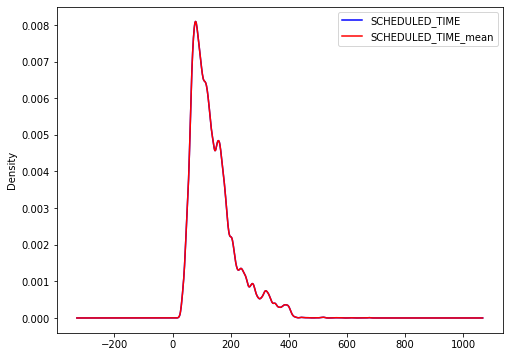

In [59]:
# Plot kde distributions of both distributions
fig = plt.figure(figsize= (8,6))
ax = fig.add_subplot(111)
df_train.SCHEDULED_TIME.plot(kind='kde', ax=ax, color = 'blue')
df_train.SCHEDULED_TIME_mean.plot(kind='kde', ax=ax, color='red')

lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='best')
plt.show()

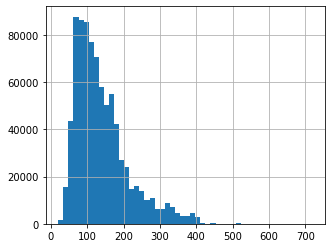

In [61]:
# Plot histogram of SCHEDULED_TIME
df_train. SCHEDULED_TIME.hist(bins=50)
plt.show()

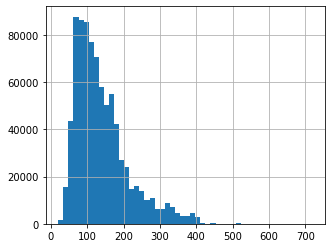

In [62]:
# Plot histogram of SCHEDULED_TIME_end_distribution
df_train['SCHEDULED_TIME_mean'].hist(bins=50)
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


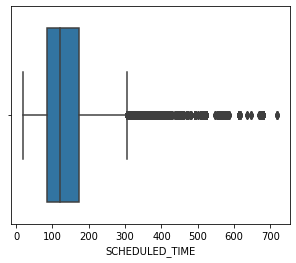

In [63]:
# Boxplot of column
sns.boxplot('SCHEDULED_TIME',data=df_train)
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


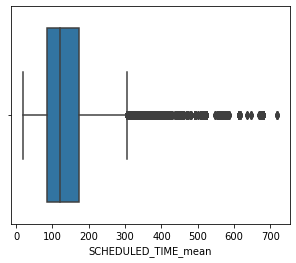

In [64]:
# Boxplot of column
sns.boxplot('SCHEDULED_TIME_mean',data=df_train)
plt.show()

##### Categorical Columns

In [65]:
# Select categorical columns
cat_cols = df_train.select_dtypes(exclude=['int', 'float']).columns
cat_set = set(cat_cols) - target_set
catt_cols = list(cat_cols)
catt_cols

['AIRLINE', 'TAIL_NUMBER', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT']

In [67]:
# Check for the categorical columns with missing values and corroborat ewith earlier findings

df_train[catt_cols].isnull().sum().sort_values()

AIRLINE                   0
ORIGIN_AIRPORT            0
DESTINATION_AIRPORT       0
TAIL_NUMBER            5981
dtype: int64

In [69]:
# Select missing categorical variables and ensure it confims with earlier observation
cat_missing = []

for cols in cat_cols:
   if df_train[cols].isnull().sum() > 0:
     cat_missing.append(cols)
   else:
     pass
  
cat_missing

['TAIL_NUMBER']

In [82]:
# Lets check the amount of unique values in each column with missing values

for col in cat_missing:
  print('----------------------------------------------')
  print(col)
  print('The number of unique values in column named', col, 'is', ( df_train[col].unique()).shape[0])
  print('The mode of distribution for the values in column named', col, 'is', ( df_train[col].mode()[0]))

----------------------------------------------
TAIL_NUMBER
The number of unique values in column named TAIL_NUMBER is 4479
The mode of distribution for the values in column named TAIL_NUMBER is N477HA


In [83]:
# create imputer function for categorical columns based on highest frequency
def impute_nan(df,variable):
    most_frequent_category=df[variable].mode()[0]
    df[variable].fillna(most_frequent_category,inplace=True)

In [85]:
# Apply function on categorical columns

for feature in cat_missing:
    impute_nan(df_train,feature)

df_train[cat_cols].head()

,AIRLINE,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT
0,AS,N407AS,ANC,SEA
1,AA,N3KUAA,LAX,PBI
2,US,N171US,SFO,CLT
3,AA,N3HYAA,LAX,MIA
4,AS,N527AS,SEA,ANC


In [90]:
# Let's confirm the total missing values in categorical dataframe
missing_values_final = []

for cols in df_train.columns:
   if df_train[cols].isnull().sum() > 0:
     missing_values_final.append(cols)
   else:
     pass
  
print(missing_values_final)

['SCHEDULED_TIME']


In [91]:
# Now let us drop column with missing values 
df_train.dropna(axis = 1, inplace= True)

df_train.head()



,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DISTANCE,SCHEDULED_ARRIVAL,CANCELLED,SCHEDULED_TIME_mean
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,1448,430,0,205.0
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,2330,750,0,280.0
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,2296,806,0,286.0
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,2342,805,0,285.0
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,1448,320,0,235.0


#### Step 2: Handling Categorical Data (Label, One-Hot, Target, Count and Catboost Encoding)

In [ ]:
# one-hot encoding without many categories
df_cat = train_missing_df[



In [ ]:
# one-hot encoding with many categories
df_cat = train_missing_df[['TAIL_NUMBER', 'CANCELLED']]
for i in df_cat.columns:
    print(len(df_cat[i].unique()))

4479
2


In [ ]:
# Show the TOP 10 categories in descending order
df_cat.TAIL_NUMBER.value_counts().sort_values(ascending=False).head(10)

N477HA    651
N476HA    637
N485HA    637
N488HA    635
N489HA    622
N491HA    616
N487HA    603
N486HA    597
N483HA    588
N493HA    577
Name: TAIL_NUMBER, dtype: int64